In [341]:
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import argparse
import locale
import math
from imutils import face_utils


ModuleNotFoundError: No module named 'imutils'

In [3]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D
from tensorflow.python.keras.layers.convolutional import MaxPooling2D
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model

In [4]:
def show_image(img):
    plt.axis("off")
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()

In [8]:

#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(128,128,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [258]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(3, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [93]:
model_1 = create_cnn()

TypeError: create_cnn() missing 3 required positional arguments: 'width', 'height', and 'depth'

## Load dataset

In [6]:
def to_vec(df):
    image_paths = []
    labels = []
    for i, row in df.iterrows():
        image_paths.append(row['image_path'])
        labels.append([row["rx"],row["ry"],row["rz"]])
#         data.append([row['image_path'],row["rx"]])
#     print([image_paths, labels])
#     df = pd.DataFrame(list(zip([image_paths, labels])), columns = ['image_path', "label"]) 

    return [image_paths, labels]

In [7]:
dataset = pd.read_csv("/mnt/notebooks/Project - Pose/PoseNet/train/t3/training_set.pkl", index_col=0)

In [8]:
dataset

,image_path,rx,ry,rz,tx,ty,tz
0,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.149999,0.032741,-0.004810,-97.379855,-76.632717,5796.087256
1,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.151979,0.028118,-0.083070,-83.581238,-64.393175,5062.087588
2,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.150890,0.029580,-0.057791,-78.612181,-58.901688,4733.616233
3,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.160499,0.010928,-0.371373,-91.505845,-79.022972,5876.522082
4,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.151126,0.031624,-0.024558,-111.413824,-91.055609,6661.815756
...,...,...,...,...,...,...,...
149995,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.101973,-0.037596,-0.003047,-117.960056,-95.364951,7066.409430
149996,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.102070,-0.035291,0.063563,-119.302908,-95.279037,7057.523388
149997,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.099335,-0.034353,0.094532,-78.039788,-53.348556,4540.251013
149998,/mnt/notebooks/Project - Pose/PoseNet/train/t3...,0.099386,-0.046591,-0.276257,-86.400386,-70.625525,5536.354176


In [9]:
dataset = dataset.dropna()

In [128]:
pd_dataset = to_vec(dataset[:20000])

In [129]:
image_paths, lables = pd_dataset[0],pd_dataset[1]

In [130]:
np.array(lables).shape

(20000, 3)

In [314]:
def load_images(paths):
    images = []
    for path in paths:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if np.array(image).sum() == 1:
            print(path)
        new_image = tf.keras.applications.vgg16.preprocess_input(image)

        images.append(new_image)
        
    return np.array(images)

In [132]:
images = load_images(image_paths)

In [133]:
split = train_test_split(images, lables, test_size=0.25, random_state=42)
(trainImagesX,testImagesX, trainY, testY ) = split

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


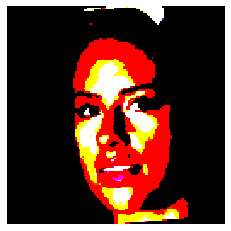

[0.16751393348384494, -0.0388423195615168, -0.0817387469715669]


In [134]:
selected_img = 30
show_image(testImagesX[selected_img])
print(testY[selected_img])

In [472]:
trainImagesX = trainImagesX / 255.0
testImagesX = testImagesX / 255.0

MemoryError: Unable to allocate array with shape (110508, 128, 128, 3) and data type float64

In [ ]:
trainImagesX.shape

In [ ]:
np.array(testY).shape

In [242]:
model = create_cnn(128,128,3, regress=True)
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

# model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
activation_5 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 32)        0         
__________

In [145]:
def compile_vgg16(lr=0.001):
    model_vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(128,128,3))
    x = model_vgg.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.20)(x)
    predictions = tf.keras.layers.Dense(3, activation="linear")(x)
    model_vgg = tf.keras.Model(inputs=model_vgg.input, outputs=predictions)


    # self.model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
    for i, layer in enumerate(model_vgg.layers):
        if i < 15:
            layer.trainable = False
        else:
            layer.trainable = True

    model_vgg.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=lr))
    
    print(model_vgg.summary())
    return model_vgg

In [15]:
def train_model(model, train_x, test_x, train_y, test_y, epochs, batch_size=32):
    model.fit(train_x, np.array(train_y), batch_size=32, epochs=epochs, verbose=1,shuffle=True)
    print(evaluate(model, test_x, test_y))

1. clean data from empty files
2. try train model
3. train vgg if no result try inception
4. my net


In [516]:
model_vgg_220 = compile_vgg16()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [494]:
train_model(model_vgg_220,trainImagesX, testImagesX, trainY, testY, epochs=4)

Epoch 1/4
15000/15000 [==============================] - 24s 2ms/sample - loss: 9388.1733
Epoch 2/4
15000/15000 [==============================] - 17s 1ms/sample - loss: 51.0835
Epoch 3/4
15000/15000 [==============================] - 17s 1ms/sample - loss: 0.0957
Epoch 4/4
15000/15000 [==============================] - 17s 1ms/sample - loss: 0.0955
[INFO] predicting pose...
The Mean Square Error is:  0.4931247481449057
None


In [521]:
model_vgg_220_1 = compile_vgg16(lr=1)
train_model(model_vgg_220_1,trainImagesX, testImagesX, trainY, testY, epochs=8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [519]:
model_vgg_220_1 = compile_vgg16(lr=10)
train_model(model_vgg_220_1,trainImagesX, testImagesX, trainY, testY, epochs=8)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [520]:
model_vgg_220_1 = compile_vgg16(lr=100)
train_model(model_vgg_220_1,trainImagesX, testImagesX, trainY, testY, epochs=8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [522]:
model_vgg_220_1 = compile_vgg16(lr=0.1)
train_model(model_vgg_220_1,trainImagesX, testImagesX, trainY, testY, epochs=8)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [523]:
model_vgg_220_1 = compile_vgg16(lr=0.0001)
train_model(model_vgg_220_1,trainImagesX, testImagesX, trainY, testY, epochs=8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [ ]:
split = train_test_split(images, lables, test_size=0.25, random_state=42)
(trainImagesX,testImagesX, trainY, testY ) = split

In [524]:
model_vgg_220_1 = compile_vgg16(lr=0.00001)
train_model(model_vgg_220_1,trainImagesX, testImagesX, trainY, testY, epochs=8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [502]:
# dripout 0.2
model_vgg_220_2 = compile_vgg16()
train_model(model_vgg_220_2,trainImagesX, testImagesX, trainY, testY, epochs=40)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

### Trying to see improve with epochs
if i do i will run random search tmw but first i'll evaluate the models againinset the evaluation set


Trying different model alexnet
a simpler model
a bigger dataset
different learning rate

In [501]:
evaluate(model_vgg_220, testImagesX, testY)

[INFO] predicting pose...
The Mean Square Error is:  0.09758186905147864


In [500]:
evaluate(model_vgg_220_1, testImagesX, testY)

[INFO] predicting pose...
The Mean Square Error is:  0.0974718806457217


In [499]:
evaluate(model_vgg_220_2, testImagesX, testY)

[INFO] predicting pose...
The Mean Square Error is:  0.09773930470079295


In [136]:
def calc_mse(y, y_pred):
    mse = ((y - y_pred)**2).mean(axis=None)
# #     summation = 0  #variable to store the summation of differences
#     n = len(y) #finding total number of items in list
#     for i in range (0,n):  #looping through each element of the list
#         difference = abs((y[i] - y_pred[i]).sum())  #finding the difference between observed and predicted value
#         squared_difference = np.sqrt(difference)  #taking square of the differene 
#         if(not math.isnan(squared_difference)):
#             summation = summation + squared_difference  #taking a sum of all the differences
#     MSE = summation/n  #dividing summation by total values to obtain average
    print( "The Mean Square Error is: " , mse)

In [430]:
# 1 batches
calc_mse(testY, p)

The Mean Square Error is:  0.4733442552582669


In [438]:
# 2 batches
calc_mse(testY, p)

The Mean Square Error is:  0.46358638723507856


In [445]:
# 20 batches
calc_mse(testY, p)

The Mean Square Error is:  0.4491790638609906


In [448]:
# 20 batches
calc_mse(testY, p)

The Mean Square Error is:  0.4491790638609906


In [146]:
model_vgg_220_1 = compile_vgg16(lr=0.00001)
train_model(model_vgg_220_1,trainImagesX, testImagesX, trainY, testY, epochs=8)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [147]:
model_vgg_220_1.predict(testImagesX[3:6])

array([[ 0.20011054, -0.06067495,  0.05777963],
       [ 0.08028145, -0.03982532, -0.11417163],
       [ 0.14486001, -0.01537884, -0.03081495]], dtype=float32)

In [149]:
model_vgg_220_1.predict(np.zeros((128,128,3)).reshape((1,128,128,3)))

array([[ 0.1765491, -0.3315804, -0.537317 ]], dtype=float32)

In [150]:
model_vgg_220_1.predict(np.ones((128,128,3)).reshape((1,128,128,3))*255)

array([[0.00262151, 2.107149  , 0.2367273 ]], dtype=float32)

## tring fit_generator

In [188]:
def create_generator(dataset, shuffle, image_size, class_mode="raw", y_col=["rx","ry","rz"], workers=0, use_multiprocessing=False):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
         preprocessing_function=tf.keras.applications.vgg16.preprocess_input
#          preprocessing_function=
    )

    generator = data_gen.flow_from_dataframe(
        dataframe=dataset,
        x_col="image_path",
        y_col=y_col,
        target_size=image_size,
        color_mode="rgb",
        batch_size=32,
        class_mode=class_mode,
        shuffle=shuffle,
        workers=workers,
        use_multiprocessing=use_multiprocessing,

    )
    return generator


In [186]:
ds_train, ds_test = train_test_split(dataset[:40000],test_size=0.25, random_state=42)

In [190]:
train_gen = create_generator(ds_train, True, (128,128), workers=10, use_multiprocessing=True)
test_gen = create_generator(ds_test, False,(128,128))
test_gen_sample = create_generator(ds_test[:5], False,(128,128), class_mode=None)

Found 30000 validated image filenames.
Found 10000 validated image filenames.
Found 5 validated image filenames.


In [170]:
pd_set = pd.DataFrame(list(zip(image_paths,  lables)), columns=["image_path","label"])

In [171]:
ds_train, ds_test = train_test_split(pd_set[:20000],test_size=0.25, random_state=42)

In [173]:
train_gen = create_generator(ds_train, True, (128,128))
test_gen = create_generator(ds_test, False,(128,128))
test_gen_sample = create_generator(ds_test[:5], False,(128,128), class_mode=None)

Found 15000 validated image filenames.
Found 5000 validated image filenames.
Found 5 validated image filenames.


Trying empty images
trying yo train only one epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


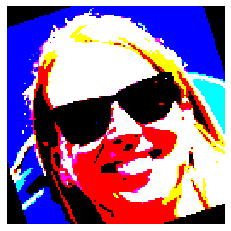

In [191]:
show_image(images[7])

In [192]:
model_vgg = compile_vgg16()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [193]:
model_vgg.predict_generator(test_gen_sample)

array([[-3.4195986, -9.242373 ,  2.3963244],
       [-4.7690215, -5.490983 ,  1.1710353],
       [ 2.89084  , -8.745096 , -3.0277016],
       [-4.745404 , -8.833796 , -8.341635 ],
       [-0.7141514, -8.360921 , -2.77503  ]], dtype=float32)

In [194]:
model_vgg.fit_generator(
        train_gen,
#         steps_per_epoch=2000,
        epochs=20)
#         validation_data=test_ge n)

Epoch 1/20
938/938 [==============================] - 227s 242ms/step - loss: 9650.2395
Epoch 2/20
938/938 [==============================] - 33s 36ms/step - loss: 4.0040
Epoch 3/20
938/938 [==============================] - 33s 36ms/step - loss: 0.0956
Epoch 4/20
938/938 [==============================] - 33s 35ms/step - loss: 0.0955
Epoch 5/20
938/938 [==============================] - 33s 35ms/step - loss: 0.0955
Epoch 6/20
938/938 [==============================] - 33s 36ms/step - loss: 0.0954
Epoch 7/20
938/938 [==============================] - 33s 35ms/step - loss: 0.0955
Epoch 8/20
938/938 [==============================] - 33s 35ms/step - loss: 0.0954
Epoch 9/20
938/938 [==============================] - 33s 36ms/step - loss: 0.0955
Epoch 10/20
938/938 [==============================] - 33s 36ms/step - loss: 0.0954
Epoch 11/20
938/938 [==============================] - 33s 36ms/step - loss: 0.0954
Epoch 12/20
938/938 [==============================] - 33s 36ms/step - loss: 0.0

In [ ]:
model_vgg.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                    steps_per_epoch=len(x_train) / 32, epochs=epochs))

In [195]:
model_vgg.predict(testImagesX[3:10])

array([[ 0.14322154, -0.01268504, -0.05072697],
       [ 0.14322154, -0.01268504, -0.05072697],
       [ 0.14322154, -0.01268504, -0.05072697],
       [ 0.14322154, -0.01268504, -0.05072697],
       [ 0.14322154, -0.01268504, -0.05072697],
       [ 0.14322154, -0.01268504, -0.05072697],
       [ 0.14322154, -0.01268504, -0.05072697]], dtype=float32)

In [159]:
model_vgg.predict(np.zeros((128,128,3)).reshape((1,128,128,3)))

array([[ 0.4614623 , -0.15461743, -0.07017204]], dtype=float32)

In [160]:
model_vgg.predict(np.ones((128,128,3)).reshape((1,128,128,3))*255)

array([[ 0.14443067, -0.01239607, -0.05454065]], dtype=float32)

In [28]:
model_vgg1 = compile_vgg16()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [298]:
weights, biases = model_vgg.layers[2].get_weights()


In [299]:
weights

array([[[[ 1.66219279e-01,  1.42701820e-01, -4.02113283e-03, ...,
           6.18828237e-02, -1.74057148e-02, -3.00644431e-02],
         [ 9.46945231e-03,  3.87477316e-03,  5.08365929e-02, ...,
          -2.77981739e-02,  1.71373668e-03,  6.82722731e-03],
         [ 6.32681847e-02,  2.12877709e-02, -1.63465310e-02, ...,
           8.80054955e-04,  6.68104272e-03, -1.41139806e-03],
         ...,
         [ 3.47490981e-03,  8.47019628e-02, -4.07223180e-02, ...,
          -1.13523193e-02, -7.48998486e-03,  3.19077494e-03],
         [ 5.97234145e-02,  4.97663505e-02, -3.23118735e-03, ...,
           1.43114366e-02,  3.03175431e-02, -4.23925705e-02],
         [ 1.33459672e-01,  4.95484173e-02, -1.78808011e-02, ...,
           2.25385167e-02,  3.02020740e-02, -2.17075031e-02]],

        [[ 2.12007999e-01,  2.10127644e-02, -1.47626130e-02, ...,
           2.29580477e-02,  1.23102348e-02, -3.08422819e-02],
         [-2.62175221e-03,  7.42094172e-03,  6.74030930e-02, ...,
          -3.06594316e

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)

In [142]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
# diff = preds.flatten() - testY
# percentDiff = (diff / testY) * 100
# absPercentDiff = np.abs(percentDiff)

In [123]:
def evaluate(model, testImagesX, testY):
    # make predictions on the testing data
    print("[INFO] predicting pose...")
    preds = model.predict(testImagesX)
    print(model.predict(testImagesX[:5]))
    # # compute the mean and standard deviation of the absolute percentage
    # # difference
    # mean = np.mean(absPercentDiff)
    # std = np.std(absPercentDiff)

    # # finally, show some statistics on our model
    # locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
    # # print("[INFO] avg. house price: {}, std house price: {}".format(
    # # locale.currency(df["price"].mean(), grouping=True),
    # # locale.currency(df["price"].std(), grouping=True)))
    # print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))
    calc_mse(testY, preds)

## Custom generator

In [216]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(128,128), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            image = cv2.imread(self.list_IDs[ID])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            X[i,] = image

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [217]:
split = train_test_split(image_paths, lables, test_size=0.25, random_state=42)
(trainImagesPathsX,testImagesPathsX, trainY, testY ) = split

In [218]:
# Parameters
params = {'dim': (128,128),
          'batch_size': 32,
          'n_channels': 3,
          'shuffle': True}


# Generators
training_generator = DataGenerator(trainImagesPathsX, trainY, **{'dim': (128,128),
          'batch_size': 32,
          'n_channels': 3,
          'shuffle': True})
validation_generator = DataGenerator(testImagesPathsX, testY, **{'dim': (128,128),
          'batch_size': 32,
          'n_channels': 3,
          'shuffle': False})


In [263]:
model = create_cnn(128,128,3, regress=True)
# opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
activation_5 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 32)        0         
__________

In [254]:
model_vgg = compile_vgg16()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [264]:
model.predict(testImagesX[3:10])

array([[-26.148296 ,  -4.8162503,  17.241724 ],
       [-25.66692  , -24.48687  ,   8.376469 ],
       [-12.662346 ,  -6.2667856,   7.0942693],
       [-29.477507 , -20.233852 ,  11.437674 ],
       [-34.582775 , -20.347532 ,  15.602876 ],
       [-15.8005905,  -9.890051 ,   6.895297 ],
       [-26.563358 , -20.925613 ,   9.3574915]], dtype=float32)

In [265]:
model.fit_generator(
        train_gen2,
         steps_per_epoch=960,
    
        epochs=30)
#         validation_data=test_ge n)

Epoch 1/30
960/960 [==============================] - 26s 27ms/step - loss: 0.1769
Epoch 2/30
960/960 [==============================] - 22s 23ms/step - loss: 0.0887
Epoch 3/30
960/960 [==============================] - 22s 23ms/step - loss: 0.0892
Epoch 4/30
960/960 [==============================] - 22s 23ms/step - loss: 0.0877
Epoch 5/30
960/960 [==============================] - 23s 24ms/step - loss: 0.0847
Epoch 6/30
960/960 [==============================] - 22s 23ms/step - loss: 0.0810
Epoch 7/30
960/960 [==============================] - 22s 23ms/step - loss: 0.0764
Epoch 8/30
960/960 [==============================] - 22s 23ms/step - loss: 0.0704
Epoch 9/30
960/960 [==============================] - 22s 23ms/step - loss: 0.0711
Epoch 10/30
960/960 [==============================] - 22s 23ms/step - loss: 0.0688
Epoch 11/30
960/960 [==============================] - 22s 23ms/step - loss: 0.0653
Epoch 12/30
960/960 [==============================] - 22s 23ms/step - loss: 0.0619
E

In [272]:
p = model.predict(testImagesX)

In [273]:
calc_mse(testY, p)

The Mean Square Error is:  1.3003014911419688


In [225]:
split = train_test_split(image_paths, lables, test_size=0.25, random_state=42)
(trainImagesPathsX,testImagesPathsX, trainY, testY ) = split

In [229]:
labels_dict = {}
for p, l in zip(image_paths, lables):
    labels_dict[p] = l

In [248]:
def preprocess_input(image):
    return image

# from skimage.io import imread
def get_input(path):
    
#     img = imread(path)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    
    return(image)


def get_output(path,label_file=None):
    
#     img_id = path.split('/')[-1].split('.')[0]
#     img_id = np.int64(img_id)
#     labels = label_file.loc[img_id].values
    return label_file[path]
    
    return(labels)
def image_generator(files, labels, batch_size = 64):
    while True:
        # Select files (paths/indices) for the batch
        batch_paths = np.random.choice(a = files, 
                                     size = batch_size)
        batch_input = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for input_path in batch_paths:
            input = get_input(input_path )
            output = get_output(input_path, label_file=labels )

            input = preprocess_input(image=input)
            batch_input += [ input ]
            batch_output += [ output ]
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )

        yield( batch_x, batch_y )

In [249]:
train_gen2 = image_generator(trainImagesPathsX, labels_dict, 32)

In [279]:
pd_test

,file name,rx,ry,rz,tx,ty,tz
0,image_03219.png,0.232823,0.258984,0.179867,53.709269,76.402880,2496.058176
1,image_00402.png,-0.119785,0.362839,-0.062090,137.927724,115.523209,2427.485141
2,image_04501.png,0.107773,-0.038309,0.116286,148.894921,113.838309,2138.816636
3,image_08929.png,0.184916,-0.129779,0.049919,169.859404,74.267703,2098.792519
4,image_07866.png,0.151122,-0.300772,0.015359,66.115997,40.895412,2718.224083
...,...,...,...,...,...,...,...
95,image_02170.png,-0.213852,0.042669,0.231739,166.217478,41.252032,1710.019103
96,image_09896.png,0.194637,0.221584,-0.152009,116.124727,34.273149,2501.398260
97,image_02063.png,0.252662,0.055673,-0.146309,7.138096,27.443552,2463.320832
98,image_09568.png,0.088536,0.295496,0.001080,84.767566,102.915104,2971.355504


In [304]:
pd_test = pd.read_csv("../valid_set/validation_set.csv",index_col=0)

In [305]:
pd_test["image_path"] = "/mnt/notebooks/Project - Pose/valid_set/images/" + pd_test["file name"]
test_image_paths, test_labels = to_vec(pd_test)

In [318]:
test_images = load_images(test_image_paths)[0]

In [325]:

new_test_images = []
for im in test_images:
    new_test_images.append(cv2.resize(im, (128,128)))

In [337]:
pd_test['image_path'][0]

'/mnt/notebooks/Project - Pose/valid_set/images/image_03219.png'

In [339]:
image = cv2.imread("/mnt/notebooks/Project - Pose/valid_set/images/image_03219.png")
image = imutils.resize(image, width=128)

show_image(image)

NameError: name 'imutils' is not defined

In [330]:
np.array(new_test_images).shape

(594, 128, 128)

In [326]:
evaluate(model, new_test_images, test_labels)

[INFO] predicting pose...


ValueError: Error when checking input: expected input_27 to have 4 dimensions, but got array with shape (128, 128)